In [1]:
import tensorflow as tf
import numpy as np
import itertools
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [3]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import initializers, optimizers
from keras.layers import Input, BatchNormalization
from keras.layers import  Dense, Flatten, Activation, Dropout, Embedding
from keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, merge, Input,Multiply
from keras.utils import np_utils
from keras.layers.wrappers import  Bidirectional
from keras.layers import *
from keras import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2 
from keras.models import load_model
import keras

Using TensorFlow backend.


In [4]:
from os import listdir
from os.path import isfile, join
import glob

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [6]:
mypath = '/home/chenming/ncrna/ncRDeep2/Data_Processing/NCP/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [7]:
my_files8 = glob.glob("/home/chenming/ncrna/ncRDeep2/Data_Processing/NCP/T*.h5")
my_files8.sort()
my_files8[0:2]

['/home/chenming/ncrna/ncRDeep2/Data_Processing/NCP/Test_0_NCP.h5',
 '/home/chenming/ncrna/ncRDeep2/Data_Processing/NCP/Test_1_NCP.h5']

In [8]:
def get_file8(fold_no): #get train and test data from file by fold number
    hf_Train = h5.File(my_files8[10+fold_no],'r')
    hf_Test = h5.File(my_files8[fold_no],'r')
    X_train = hf_Train['Train_Data'] # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Train['Label']      # Get train label
    Y_train = np.array(Y_train)
    X_test = hf_Test['Test_Data']     # Get test set
    X_test = np.array(X_test)
    Y_test = hf_Test['Label']       # Get test label
    Y_test = np.array(Y_test)
    Y_train = np_utils.to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = np_utils.to_categorical(Y_test, 13)    #  Process the label of test
    return X_train, Y_train, X_test, Y_test

In [9]:
my_files8[20]
hf_val = h5.File(my_files8[20],'r')
X_val = hf_val['Test_Data']     # Get test set
X_val = np.array(X_val)
Y_val = hf_val['Label']       # Get test label
Y_val = np.array(Y_val)
Y_val = np_utils.to_categorical(Y_val, 13)    #  Process the label of test
X_val[:,:,0:4].shape

(2600, 750, 4)

In [10]:
#class_names = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
class_names = ['5S_rRNA', '5.8S_rRNA', 'tRNA', 'ribozymes', 'CD-box', 'miRNA', 'Intron_gpI', 'Intron_gpII', 'HACA-box', 'riboswitch', 'IRES', 'leader', 'scaRNA']
class_names

['5S_rRNA',
 '5.8S_rRNA',
 'tRNA',
 'ribozymes',
 'CD-box',
 'miRNA',
 'Intron_gpI',
 'Intron_gpII',
 'HACA-box',
 'riboswitch',
 'IRES',
 'leader',
 'scaRNA']

In [11]:
def model_conv(f1,k1,f2,k2): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 3))
    
    x=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)

    x=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    #x=Conv1D(filters=32,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    #x = BatchNormalization()(x)
    #x=Dropout(0.2)(x)
    #x=Activation('relu')(x)
    #x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    xx=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs2)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)

    xx=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)
    
    x2=keras.layers.concatenate([xx,x])
    
    x2=Conv1D(filters=64,kernel_size=4,strides=1,kernel_initializer=initializers.random_uniform()) (x2)
    x2 = BatchNormalization()(x2)
    x2=Dropout(0.2)(x2)
    x2=Activation('relu')(x2)
    x2=MaxPooling1D(pool_size=2, strides=2)(x2)

    x2=Flatten()(x2)

    x3=Dense(128,)(x2)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(32,)(x3)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(13, activation='softmax',  )(x3)

    model = Model(inputs=[inputs1, inputs2], outputs=x3)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [30]:
X_train, Y_train, X_test, Y_test = get_file8(0)


In [31]:
model = model_conv(512, 20, 128, 6)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 750, 3)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 750, 4)       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 731, 512)     31232       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 731, 512)     41472       input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [42]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_conv(512, 20, 128, 6)
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],X_train[:,:,4:7]], Y_train, validation_data=([X_test[:,:,0:4],X_test[:,:,4:7]], Y_test), epochs=500, verbose=0, callbacks=[es])
    #model.save_weights("Checkpoints/Dense_RNAfold_1003conv_%i_fold.h5" %i)
    y = model.predict([X_test[:,:,0:4],X_test[:,:,4:7]])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.8971518987341772, 0.88875, 0.8986947879384855, 0.891474523524675, 0.8887877376798968)
(0.9082278481012658, 0.9038461538461537, 0.907439343791433, 0.9047842170367161, 0.9006437994566674)
(0.9018987341772152, 0.9011538461538463, 0.9052470396046035, 0.9018026563436975, 0.8938988154443211)
(0.8924050632911392, 0.8884615384615385, 0.8972998600662755, 0.8904881606290085, 0.8837526317081961)
(0.8987341772151899, 0.8954807692307691, 0.8973514049940611, 0.894762286300844, 0.8905245204529618)
(0.9129746835443038, 0.911923076923077, 0.9118373749433952, 0.910486100032727, 0.9058706653457148)
(0.9066455696202531, 0.9005769230769232, 0.9095424230863889, 0.9020537717517487, 0.8991866600233213)
(0.8781645569620253, 0.8754807692307692, 0.8796513983464194, 0.8734117315874411, 0.8686855640405448)
(0.9082278481012658, 0.903846153846154, 0.9113186136343395, 0.9060139788276551, 0.9007344385105593)
(0.9082278481012658, 0.9038461538461537, 0.9072011756869008, 0.9046213846287324, 0.9006511377232183)


In [43]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.9012658227848102
0.8973365384615384
0.9025583422092301
0.8979898810663247
0.8932735970385401


In [75]:

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train,ncp_train_lines], Y_train, validation_data=([X_test,ncp_test_lines], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test,ncp_test_lines])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 17s 3ms/step - loss: 2.3500 - acc: 0.2331 - val_loss: 1.9750 - val_acc: 0.3576
Epoch 2/500
5688/5688 [==============================] - 10s 2ms/step - loss: 1.9986 - acc: 0.3609 - val_loss: 1.8441 - val_acc: 0.4272
Epoch 3/500
5688/5688 [==============================] - 10s 2ms/step - loss: 1.8016 - acc: 0.4369 - val_loss: 1.7514 - val_acc: 0.5443
Epoch 4/500
5688/5688 [==============================] - 9s 2ms/step - loss: 1.6849 - acc: 0.4889 - val_loss: 1.6762 - val_acc: 0.5601
Epoch 5/500
5688/5688 [==============================] - 9s 2ms/step - loss: 1.5726 - acc: 0.5325 - val_loss: 1.6355 - val_acc: 0.5902
Epoch 6/500
5688/5688 [==============================] - 10s 2ms/step - loss: 1.4811 - acc: 0.5723 - val_loss: 1.5108 - val_acc: 0.6028
Epoch 7/500
5688/5688 [==============================] - 10s 2ms/step - loss: 1.3870 - acc: 0.6041 - val_loss: 1.4585 - val_acc: 0.6377
Epo

In [15]:
def Conv1Dme(f, k, xo):
    x1o=Conv1D(filters=f,kernel_size=k,strides=1,padding="same",kernel_initializer=initializers.random_uniform()) (xo)
    x1o = BatchNormalization()(x1o)
    x1o=Dropout(0.2)(x1o)
    x1o=Activation('relu')(x1o)
    #x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    return x1o

In [12]:
def dense_block_1(xin, f, k):
    f1 = f
    k1 = k

    x1 = Conv1Dme(f1, k1, xin)
    x11 = Conv1Dme(f1, k1, x1)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x1=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    return x1

In [29]:
def model_dense2(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 3))
    
    x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    x1 = Conv1Dme(128, 3, x1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    #x1 = dense_block_1(x1, 512, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    #xx1 = Conv1Dme(64, 3, inputs2)
    #xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    #xx1 = dense_block_1(xx1, 128, 4)
    #xx1 = dense_block_1(xx1, 256, 5)
    #xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    #xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    #xxx = Conv1Dme(64, 3, xxx)
    #xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
        
    xf=Flatten()(x1)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [30]:
model = model_dense2()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 750, 4)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 750, 3)       0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 750, 7)       0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 750, 128)     2816        concatenate_17[0][0]             
__________

In [31]:
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train,ncp_train_lines], Y_train, validation_data=([X_test,ncp_test_lines], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test,ncp_test_lines])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 20s 4ms/step - loss: 2.2632 - acc: 0.2430 - val_loss: 2.8036 - val_acc: 0.1313
Epoch 2/500
5688/5688 [==============================] - 10s 2ms/step - loss: 1.9328 - acc: 0.3637 - val_loss: 2.8606 - val_acc: 0.0886
Epoch 3/500
5688/5688 [==============================] - 11s 2ms/step - loss: 1.7752 - acc: 0.4214 - val_loss: 2.8145 - val_acc: 0.1313
Epoch 4/500
5688/5688 [==============================] - 11s 2ms/step - loss: 1.6091 - acc: 0.4852 - val_loss: 2.6736 - val_acc: 0.1646
Epoch 5/500
5688/5688 [==============================] - 11s 2ms/step - loss: 1.4127 - acc: 0.5624 - val_loss: 2.1295 - val_acc: 0.3481
Epoch 6/500
5688/5688 [==============================] - 11s 2ms/step - loss: 1.2719 - acc: 0.6123 - val_loss: 2.0704 - val_acc: 0.3782
Epoch 7/500
5688/5688 [==============================] - 11s 2ms/step - loss: 1.1534 - acc: 0.6472 - val_loss: 1.9803 - val_acc: 0.3576
E

In [32]:
for i in range(3):
    model = model_dense2()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train,ncp_train_lines], Y_train, validation_data=([X_test,ncp_test_lines], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test,ncp_test_lines])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9161392405063291
0.9066455696202531
0.9018987341772152


In [33]:
def model_dense2(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 3))
    
    x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    x1 = Conv1Dme(64, 3, x1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 4)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
            
    xf=Flatten()(x1)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [34]:
for i in range(3):
    model = model_dense2()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train,ncp_train_lines], Y_train, validation_data=([X_test,ncp_test_lines], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test,ncp_test_lines])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9066455696202531
0.8971518987341772
0.9066455696202531


In [35]:
def model_dense3(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 3))
    
    #x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    x1 = Conv1Dme(128, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    #x1 = dense_block_1(x1, 512, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    xx1 = Conv1Dme(128, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    xx1 = dense_block_1(xx1, 128, 3)
    xx1 = dense_block_1(xx1, 256, 5)
    xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    #xxx = Conv1Dme(64, 3, xxx)
    #xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [37]:
for i in range(3):
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train,ncp_train_lines], Y_train, validation_data=([X_test,ncp_test_lines], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test,ncp_test_lines])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9145569620253164
0.9098101265822784
0.9113924050632911


In [13]:
def model_dense3(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 3))
    
    #x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    x1 = Conv1Dme(128, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    #x1 = dense_block_1(x1, 256, 5)
    #x1 = dense_block_1(x1, 512, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    xx1 = Conv1Dme(128, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    xx1 = dense_block_1(xx1, 128, 3)
    xx1 = dense_block_1(xx1, 256, 5)
    #xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    #xxx = Conv1Dme(64, 3, xxx)
    #xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
    xxx = dense_block_1(xxx, 256, 3)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [16]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],X_train[:,:,4:7]], Y_train, validation_data=([X_test[:,:,0:4],X_test[:,:,4:7]], Y_test), epochs=500, verbose=0, callbacks=[es])
    model.save_weights("Checkpoints/Dense_NCP_%i_fold.h5" %i)
    y = model.predict([X_val[:,:,0:4],X_val[:,:,4:7]])
    y_test_non_category = [ np.argmax(t) for t in Y_val ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.9107692307692308, 0.9107692307692308, 0.9269522968236927, 0.9142826366648461, 0.9043754147575971)
(0.926923076923077, 0.9269230769230768, 0.9380730099488949, 0.9289984922018112, 0.9215994359009458)
(0.9215384615384615, 0.9215384615384613, 0.9318351989158346, 0.9238751036242545, 0.9156023828005241)
(0.9176923076923077, 0.9176923076923077, 0.9241667827233526, 0.919496419870031, 0.9111026156311214)
(0.9338461538461539, 0.9338461538461539, 0.937211837424994, 0.9346302433641956, 0.9284958343244213)
(0.9176923076923077, 0.9176923076923077, 0.9273342681592146, 0.9194215297205092, 0.9114379457656654)
(0.935, 0.9349999999999999, 0.9396042492059434, 0.935792009665597, 0.9298872355692777)
(0.94, 0.94, 0.9457416939893039, 0.9410732820902415, 0.9353520224199914)
(0.9096153846153846, 0.9096153846153847, 0.930997943573854, 0.9144891779870145, 0.9037373538521601)
(0.9338461538461539, 0.9338461538461538, 0.938378868960953, 0.9348974457304597, 0.9285571663975988)


In [17]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.9246923076923078
0.9246923076923078
0.9340296149726038
0.9266956340918961
0.9190147407419303


In [85]:
auc_mat_750c1

array([[[0.92653846],
        [0.92653846],
        [0.93435634],
        [0.92830206],
        [0.92085019]]])

In [81]:
acc = [0]*50
loss = [0]*50
val_acc = [0]*50
val_loss = [0]*50
for i in range(1):
    i=3
    f1 = history_750c1['fold%i'%i]
    #print(len(f1['acc']))
    f2 = f1['acc']
    f3 = f1['loss']
    f4 = f1['val_acc']
    f5 = f1['val_loss']
    for j in range(50):
        acc[j] = acc[j]+f2[j]
        loss[j] = loss[j]+f3[j]
        val_acc[j] = val_acc[j]+f4[j]
        val_loss[j] = val_loss[j]+f5[j]

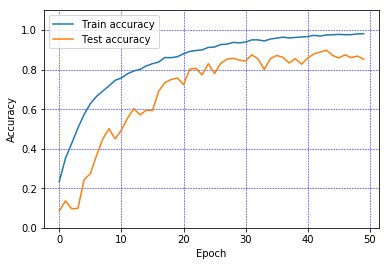

In [82]:
plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Test accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.grid(color='b', linestyle='--', linewidth=0.5)
plt.legend()

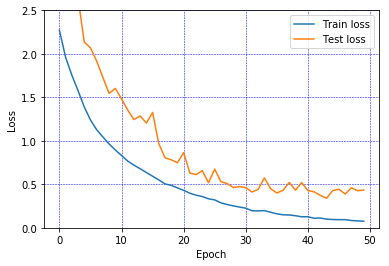

In [83]:
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Test loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 2.5)
plt.grid(color='b', linestyle='--', linewidth=0.5)
plt.legend()

In [40]:
for i in range(3):
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train,ncp_train_lines], Y_train, validation_data=([X_test,ncp_test_lines], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test,ncp_test_lines])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9161392405063291
0.9066455696202531
0.9129746835443038


In [44]:
precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
classification_reports = classification_report(y_test_non_category, y_predict_non_category)
print(auc,recall,precision,fscore,mcc)

(0.9129746835443038, 0.9084615384615383, 0.913858590348216, 0.9087949563028617, 0.9060828852036866)


In [42]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    FONT_SIZE = 10
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n============================")
    else:
        #cm = np.asfarray(cm,float64)
        print('Confusion matrix, without normalization\n============================')
    #print(cm)
    plt.figure(figsize=(5*2, 4*2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=FONT_SIZE)
    plt.yticks(tick_marks, classes, fontsize=FONT_SIZE)
    fmt = '.3f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=FONT_SIZE)
    plt.xlabel('Predicted label', fontsize=FONT_SIZE)
    plt.savefig('Conf_mat_avg.pdf')
    plt.show()

Normalized confusion matrix


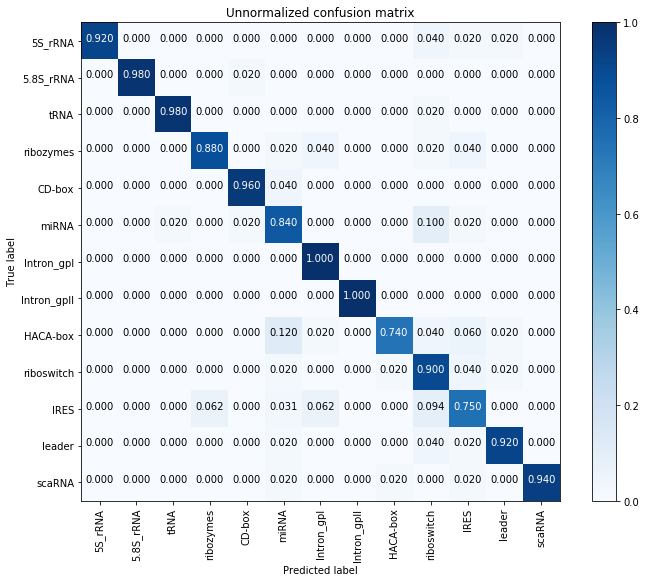

In [47]:
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                        title='Unnormalized confusion matrix')